In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import pgeocode as pg
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Id,Tipo,FechaConstruccion,FechaReforma,Plantas,Plan,PAU,CatParcela,PerimParcela,Superficie,...,AguaCorriente,FosaSeptica,Situacion,CP,ProxCarretera,ProxCallePrincipal,ProxViasTren,Estado,RatingEstrellas,Precio
0,1,Chalet individual,2003,2003,2,Antiguo,0,Residencial unifamiliar,79.25,785.03,...,1,0,Interior,60061,0,0,0,5,3.5,375497
1,2,Chalet individual,1976,1976,1,Antiguo,0,Residencial unifamiliar,97.54,891.87,...,1,0,Frontal 2 lados,50018,0,1,0,8,3.0,339946
2,3,Chalet individual,2001,2002,2,Antiguo,0,Residencial unifamiliar,82.91,1045.16,...,1,0,Interior,60061,0,0,0,5,3.5,402511
3,4,Chalet individual,1915,1970,2,Nuevo,0,Residencial unifamiliar,73.15,887.22,...,1,0,Esquina,62451,0,0,0,5,3.5,272706
4,5,Chalet individual,2000,2000,2,Antiguo,0,Residencial unifamiliar,102.41,1324.80,...,1,0,Frontal 2 lados,60706,0,0,0,5,4.0,450236


In [3]:
df.index = df['Id']
df.drop(['Id', 'AguaCorriente', 'GasNatural', 'FosaSeptica'], axis=1, inplace=True)
df.dropna(inplace=True)
variables_reales = df.columns[df.dtypes == 'float64']
variables_categoricas = df.dtypes[df.dtypes == 'object'].index
variables_enteras = df.columns[df.dtypes == 'int64']
print('Variables reales: ', variables_reales)
print('Variables categoricas: ', variables_categoricas)
print('Variables enteras: ', variables_enteras)

Variables reales:  Index(['PerimParcela', 'Superficie', 'RatingEstrellas'], dtype='object')
Variables categoricas:  Index(['Tipo', 'Plan', 'CatParcela', 'Formato', 'TipoDesnivel', 'Desnivel',
       'Situacion'],
      dtype='object')
Variables enteras:  Index(['FechaConstruccion', 'FechaReforma', 'Plantas', 'PAU', 'Aseos',
       'Habitaciones', 'Garaje', 'Piscina', 'Vallada', 'CallePavimentada',
       'Callejon', 'CP', 'ProxCarretera', 'ProxCallePrincipal', 'ProxViasTren',
       'Estado', 'Precio'],
      dtype='object')


In [4]:
def minmax_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].min()) / (df[variable].max() - df[variable].min())
    return df

def zscore_norm(df, variables_reales):
    for variable in variables_reales:
        df[variable] = (df[variable] - df[variable].mean()) / df[variable].std()
    return df

def one_hot_encoding(df, variables_categoricas):
    return pd.get_dummies(df, columns=variables_categoricas, dtype=np.int64)

def label_encoding(df, variables_categoricas):
    for variable in variables_categoricas:
        df[variable] = df[variable].astype('category').cat.codes
    return df

def extract_postal_hierarchy(df):
    df['CP'] = df['CP'].astype(str)
    df['postal_group'] = df['CP'].str[0]
    df['region'] = df['CP'].str[:3]
    df['specific_location'] = df['CP']
    return df

variables_enteras = variables_enteras.drop(['Precio', 'CP'])

df = minmax_norm(df, variables_reales)
df = minmax_norm(df, variables_enteras)
df = one_hot_encoding(df, variables_categoricas)
df = extract_postal_hierarchy(df)
#create a column 'Reformada' that has a 1 if 'FechaConstruccion' != 'FechaReforma' and 0 otherwise
df['Reformada'] = df['FechaConstruccion'] != df['FechaReforma']
df['Reformada'] = df['Reformada'].astype(int)

df.head()

,FechaConstruccion,FechaReforma,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,...,Desnivel_Moderado,Situacion_Esquina,Situacion_Frontal 2 lados,Situacion_Frontal 3 lados,Situacion_Interior,Situacion_Trasero,postal_group,region,specific_location,Reformada
Id,,,,,,,,,,,,,,,,,,,,,
1,0.946154,0.883333,1.0,0.0,0.150698,0.033420,0.75,0.6,1.0,0.0,...,0,0,0,0,1,0,6,600,60061,1
2,0.738462,0.433333,0.0,0.0,0.202073,0.038795,0.50,0.4,1.0,0.0,...,0,0,1,0,0,0,5,500,50018,1
3,0.930769,0.866667,1.0,0.0,0.160979,0.046508,0.75,0.4,1.0,0.0,...,0,0,0,0,1,0,6,600,60061,1
4,0.269231,0.333333,1.0,0.0,0.133564,0.038561,0.25,0.5,1.0,0.0,...,0,1,0,0,0,0,6,624,62451,1
5,0.923077,0.833333,1.0,0.0,0.215752,0.060577,0.75,0.7,1.0,0.0,...,0,0,1,0,0,0,6,607,60706,1


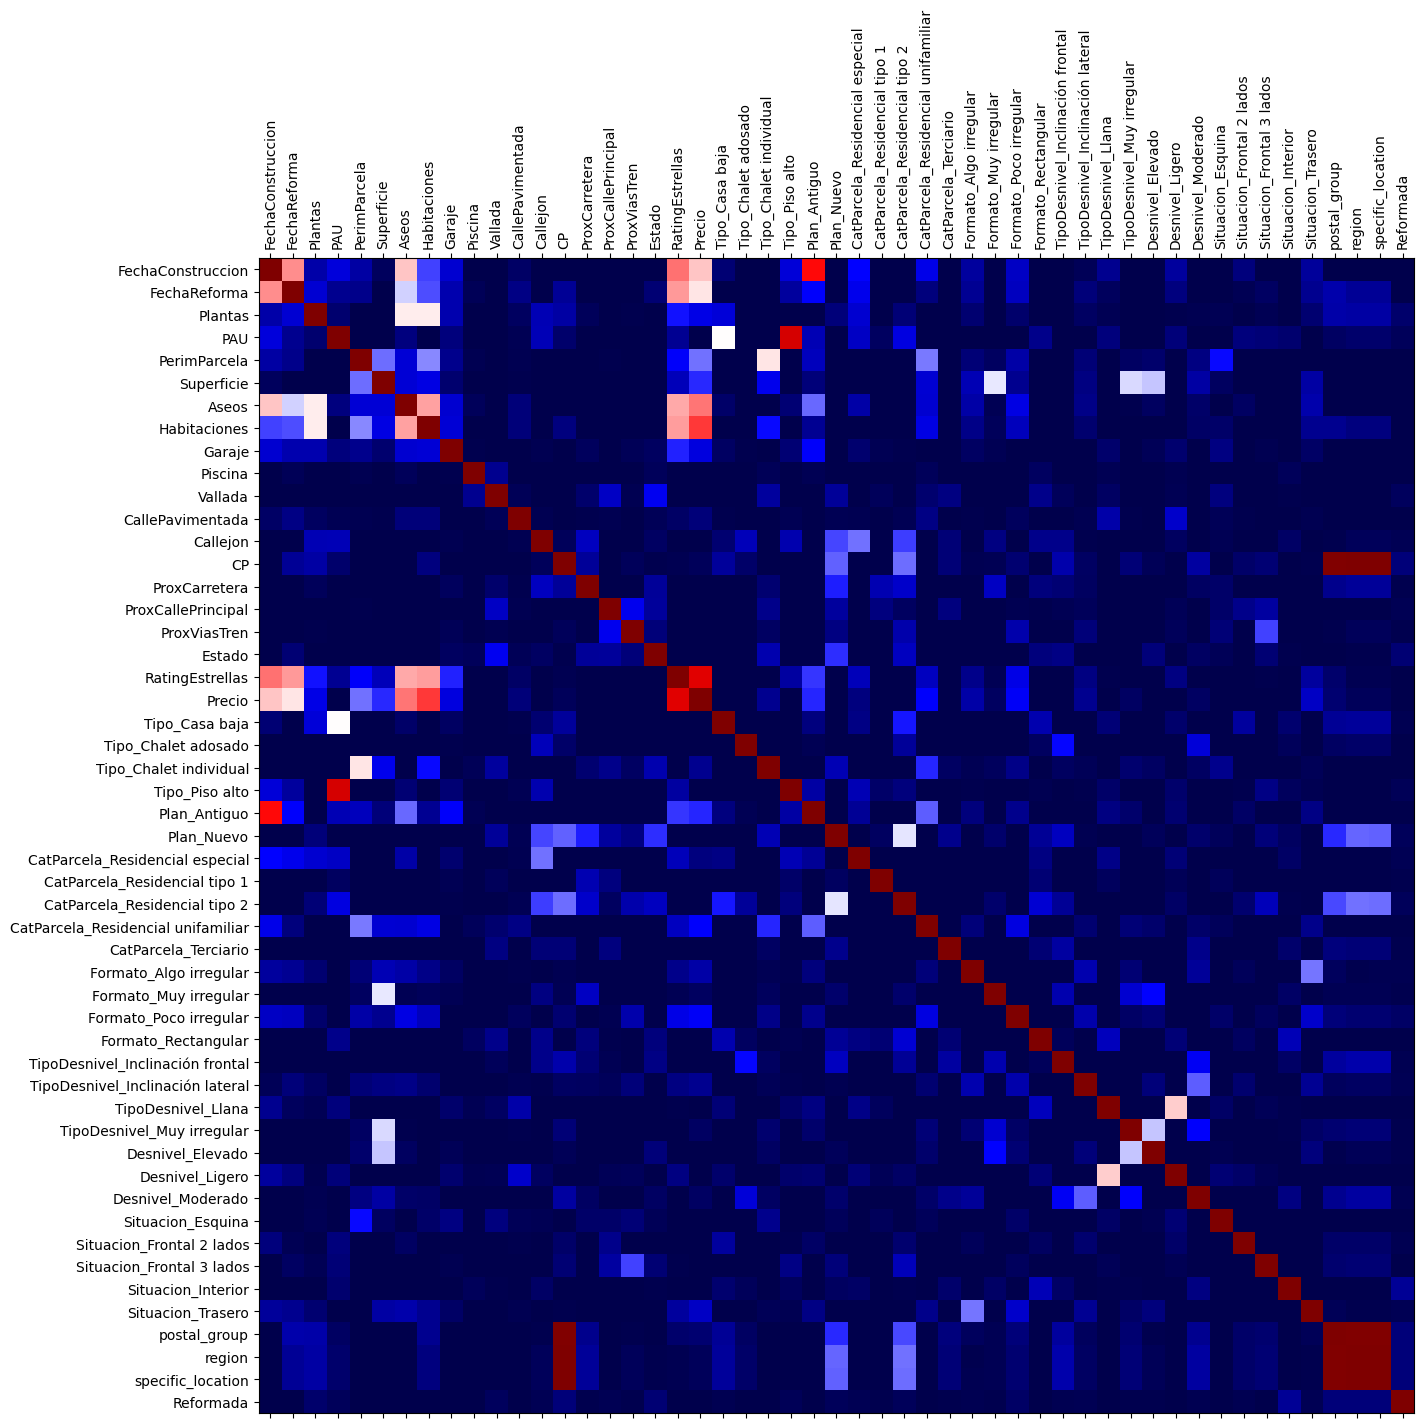

In [5]:
# plot correlation matrix of columns in the dataframe
def plot_correlation_matrix(df):
    corr = df.corr()
    #sort the correlation, place the most correlated variables next to price
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(corr, cmap='seismic', vmin=0, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

plot_correlation_matrix(df)

In [6]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

train_size = 0.9
train = df.sample(frac=train_size, random_state=1)
test = df.drop(train.index)

X_train, y_train = x_y_split(train, 'Precio')
X_test, y_test = x_y_split(test, 'Precio')
X_train.head()

,FechaConstruccion,FechaReforma,Plantas,PAU,PerimParcela,Superficie,Aseos,Habitaciones,Garaje,Piscina,...,Desnivel_Moderado,Situacion_Esquina,Situacion_Frontal 2 lados,Situacion_Frontal 3 lados,Situacion_Interior,Situacion_Trasero,postal_group,region,specific_location,Reformada
Id,,,,,,,,,,,,,,,,,,,,,
555,0.946154,0.900000,1.0,0.0,0.219179,0.043586,0.75,0.6,1.0,0.0,...,0,0,0,0,1,0,6,606,60645,1
475,0.923077,0.833333,0.0,1.0,0.068509,0.018837,0.50,0.4,1.0,0.0,...,0,0,0,0,1,0,5,500,50012,1
671,0.961538,0.916667,1.0,0.0,0.147271,0.034275,0.75,0.5,1.0,0.0,...,0,0,1,0,0,0,6,600,60061,1
494,0.615385,0.166667,0.0,0.0,0.167804,0.030994,0.25,0.4,1.0,0.0,...,0,0,0,0,1,0,5,500,50014,1
676,0.753846,0.466667,1.0,1.0,0.010281,0.004623,0.50,0.5,1.0,0.0,...,0,0,0,0,1,0,6,606,60646,1


In [7]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return y_pred

def visualize_test(y_test, y_pred, ax, model_name):
    paired = sorted(list(zip(y_test, y_pred)))
    y_test_sorted, y_pred_sorted = zip(*paired)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape= mean_absolute_percentage_error(y_test, y_pred)
    # print in scientific notation format
    print('MSE: {:.2e}'.format(mse))
    print('MAE: {:.2e}'.format(mae))
    print('MAPE: {:.2e}'.format(mape))
    # plot y_test and y_pred values to visualize the model performance
    num_range = np.arange(0, len(y_test))
    ax.plot(y_test_sorted, label='y_test', marker='*', color='blue')
    ax.plot(y_pred_sorted, label='y_pred', marker='.', color='red')
    ax.set_title(f'y_test vs y_pred {model_name}')
    ax.legend()

MSE: 9.17e+09
MAE: 6.47e+04
MAPE: 2.03e-01


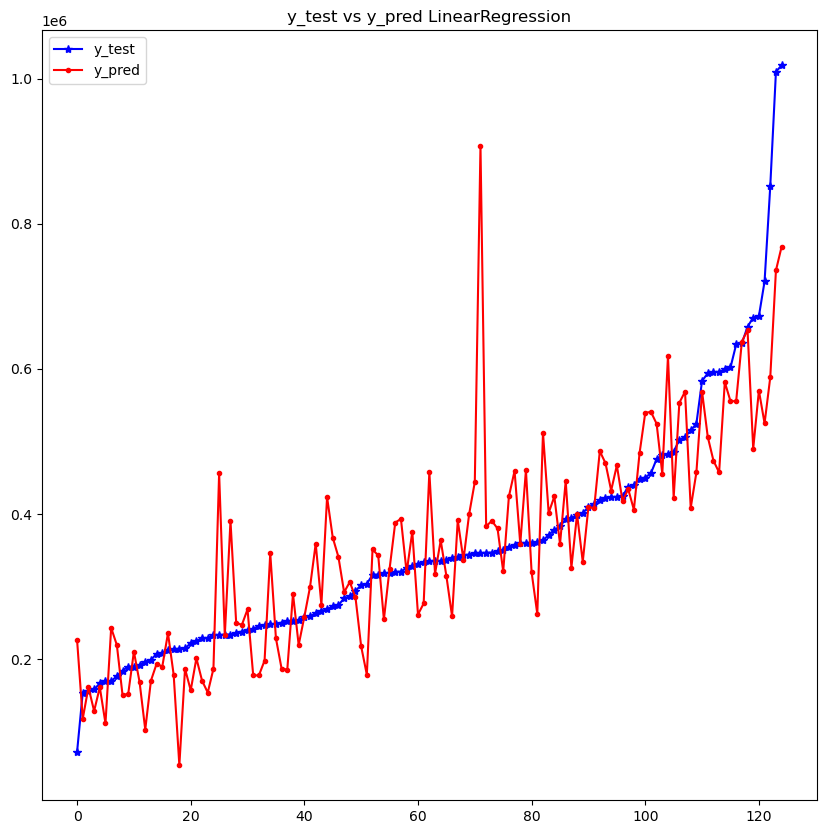

In [8]:
best_combination = {'recall': 0, 'model': None, 'norm': None, 'sampling': None, 'trained_model': None}
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model = LinearRegression()
model_name = model.__class__.__name__
trained_model = train_model(model, X_train, y_train)
y_pred = test_model(trained_model, X_test, y_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)

MSE: 9.17e+09
MAE: 6.47e+04
MAPE: 2.03e-01
MSE: 1.76e+10
MAE: 9.40e+04
MAPE: 2.93e-01
MSE: 7.71e+09
MAE: 5.86e+04
MAPE: 1.71e-01
MSE: 7.51e+09
MAE: 5.82e+04
MAPE: 1.64e-01
MSE: 8.90e+09
MAE: 6.54e+04
MAPE: 1.98e-01
MSE: 7.61e+09
MAE: 4.92e+04
MAPE: 1.38e-01
MSE: 9.01e+09
MAE: 4.79e+04
MAPE: 1.38e-01
MSE: 8.77e+09
MAE: 6.07e+04
MAPE: 1.83e-01


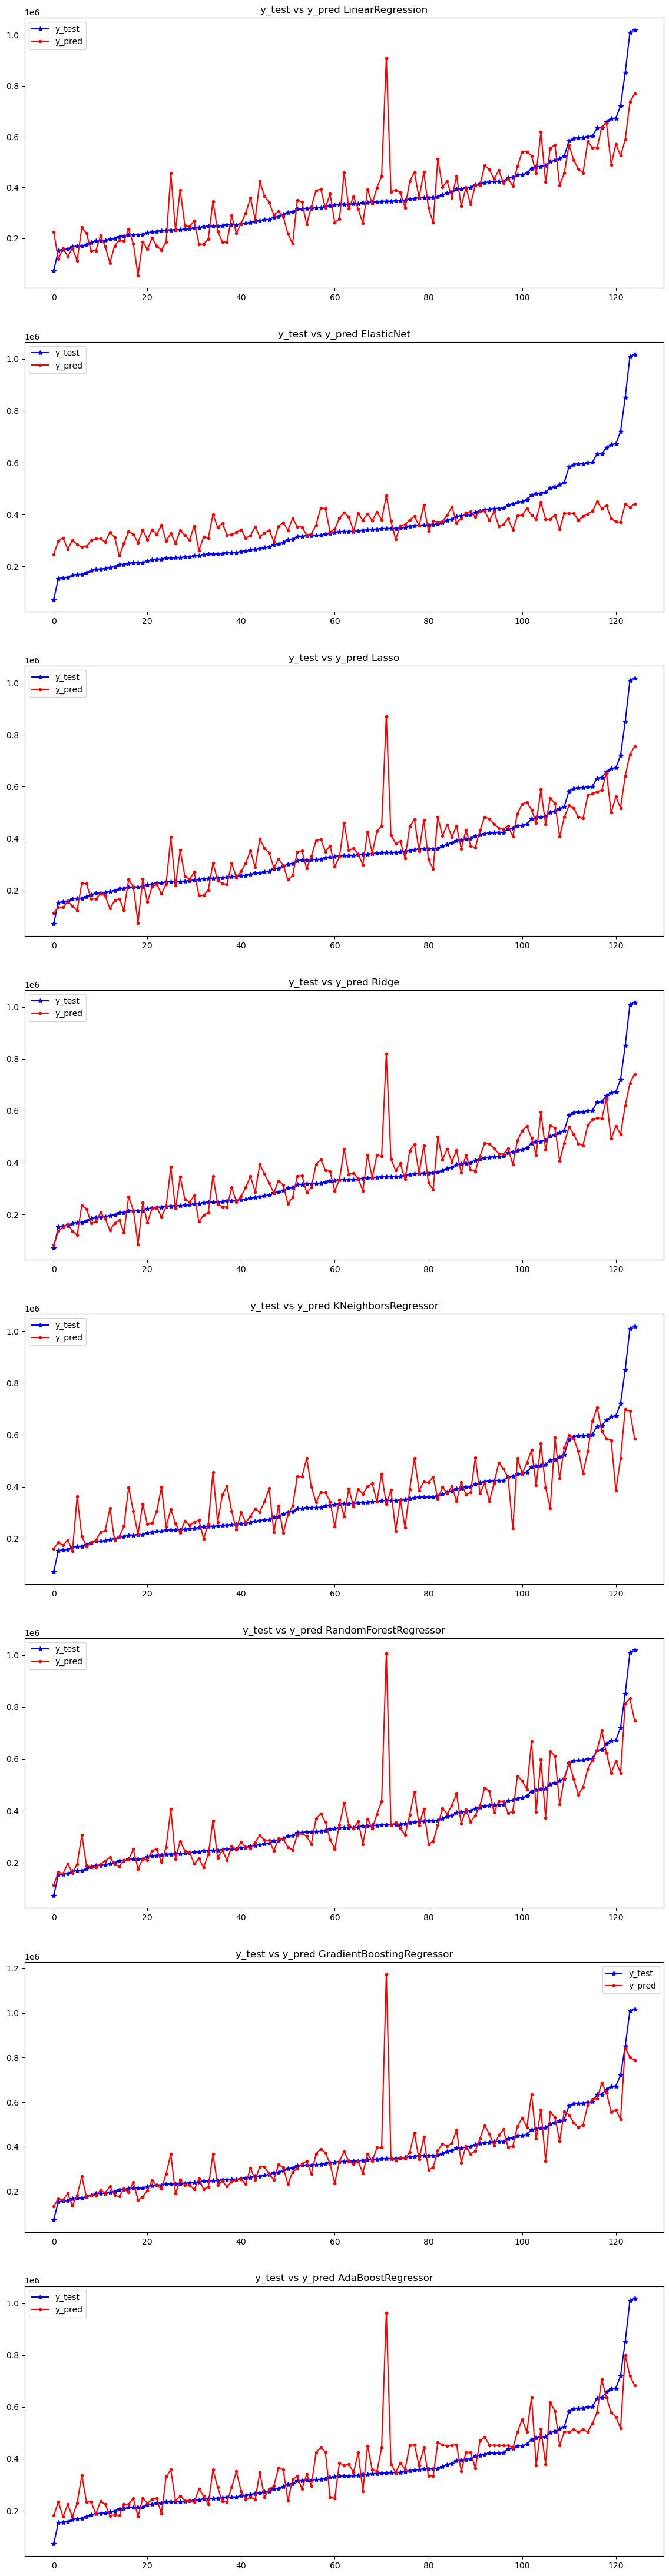

In [9]:
models = [LinearRegression(), ElasticNet(), Lasso(), Ridge(), KNeighborsRegressor(), RandomForestRegressor(), GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000), AdaBoostRegressor()]
# cols and rows for subplots according to number of models
fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(14, len(models)*7))

for i, model in enumerate(models):
    model_name = model.__class__.__name__
    trained_model = train_model(model, X_train, y_train)
    y_pred = test_model(trained_model, X_test, y_test)
    visualize_test(y_test, y_pred, ax=axes[i], model_name=model_name)

plt.show()


In [10]:
grad_boost = GradientBoostingRegressor()

distributions = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 7),
    'min_samples_split': uniform(0.01, 0.2),
    'min_samples_leaf': uniform(0.01, 0.1),
    'subsample': uniform(0.8, 0.2),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

clf = RandomizedSearchCV(grad_boost, distributions, random_state=0, n_iter=10000, verbose=1, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


MSE: 6.94e+09


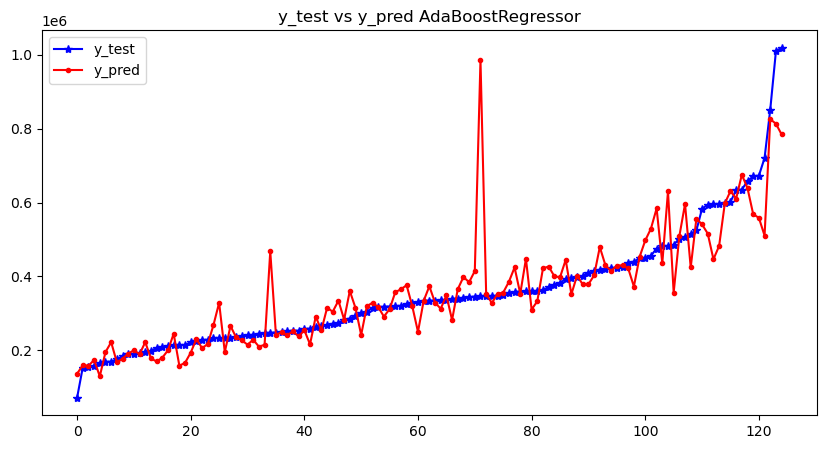

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
visualize_test(y_test, y_pred, ax=axes, model_name=model_name)